In [1]:
# Check Sumbarine Melt (Qsm)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import Functions as fun

In [ ]:
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'
path3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind_notide/'
path4 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nBathy/' # Removed near glacier spike
path5 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind1_nSill/'
path6 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/'
path7 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS/'
path8 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS_n/'

taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)
taum3 = np.array([0, 0.1, 0.3, 0.8, 1.5]) # No-tide cases
taum4 = np.array([0, 0.1, 0.3, 0.9, 1.5, -0.1, -0.3, -0.9, -1.5])
taum5 =taum4
taum6 = np.array([0, 0.1, 0.3, -0.1, -0.3, 0.9, 1.5, -0.9, -1.5])
taum7 = taum6

In [ ]:
file0 = xr.open_dataset(path7+'state_002.nc')
# De-duplicating data
file = file0.isel(T=~file0.get_index("T").duplicated())
state = file.isel(X=slice(200), Xp1=slice(201), Y=slice(35, 45), Yp1=slice(35, 45))
zrange = [0, -400]
state = state.sel(Z=slice(zrange[0],zrange[1]))
    
Grid = xr.open_dataset(path7+'grid.nc')
grid = Grid.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))
grid = grid.sel(Z=slice(zrange[0],zrange[1]))
area = grid.drF * grid.dyF * grid.HFacC

xid = 1
depths = -1*state.Z.data
A = area.isel(X=xid).data
#Tng = (state.Temp.data[:,:,:,xid]*A).sum(axis=(1,2)) / A.sum()

# Potential temp
Ttz = state.Temp.data[:,:,:,xid].mean(2) # Temp
Tng = np.trapz(Ttz, depths, axis=1)
# Pressure and Density
pres = gsw.p_from_z(-depths, -48.25)
Stz = state.S.data[:,:,:,xid].mean(2) 
    
N2, Pmid = gsw.Nsquared(Stz,Ttz,pres, -48.25,axis=1)

mid_depths = (depths[1:]+depths[:-1])/2
Nsq_ng = np.trapz(N2, mid_depths, axis=1)

In [ ]:
Nsq_ng

## Wind Forcing

In [2]:
# Zonal Wind Stress
externForcingCircle = 30*86400 # Forcing period in second
externForcingPeriod = 0.25*86400 # time interval between forcing field records
nt = int(externForcingCircle / externForcingPeriod)
model_time = np.linspace(0,externForcingCircle,nt+1);
up = 0*86400 / externForcingPeriod
down = 2.5*86400 / externForcingPeriod
ramp = 0.5*86400 / externForcingPeriod
#taum = taum1.copy() # maximum wind stress
#taum = taum2.copy()
#taum = taum3.copy()
taum = [0,.1,.3,.9]
#taum = [0,.1,.3]
zonal_wind_stress = np.zeros((len(taum),nt))

nf = int(down+ramp)

## Wind Events
forcing = np.zeros((len(taum),nf))
for i in range(0,len(taum)):
    tau = taum[i]
    for j in range(nf):
        if j <= up - 1:
            forcing[i, j] = 0
        elif j < up + ramp - 1:
            forcing[i, j] = tau * (j - (up - 1)) / ramp
        elif j > down-1:
            forcing[i, j] = tau * (down + ramp - 1 - j) / ramp
        else:
            forcing[i, j] = tau

zonal_wind_stress[:,:nf] = forcing

rt = 1 # number of repeated wind events
zonal_wind_stress[:,:nf*rt] = np.tile(forcing, rt)


## Lasting Wind
# for i in range(0,len(taum)):
#     tau = taum[i]
#     for j in range(nt):
#         if j <= up - 1:
#             zonal_wind_stress[i,j] = 0
#         elif j < up + ramp - 1:
#             zonal_wind_stress[i,j] = tau * (j - (up - 1)) / ramp
#         else:
#             zonal_wind_stress[i,j] = tau

wind = np.concatenate((np.zeros((len(taum),1)), zonal_wind_stress), axis=1)

In [ ]:
wind

## Submarine Melting
## Near-glacier Temperature & Stratification

In [ ]:
# Down-fjord wind
# Taux = [0, 0.1, 0.3, 0.8, 1.5]
#caseid = [3,4,8,11,13]
#caseid = [3,7,10]
#caseid = [1,2,3,4,5]
#caseid = [1,2,3,4,5]

# Up-fjord wind
#caseid = [3,2,6,10,12]
#caseid = [2,5,9]
#caseid = [1,6,7,8,9]

caseid = [1,2,3,4,5]

zrange = [0, -400] # Depth range to calculate Qsm, Temp, and Nsq
Qsm = []
Temp_ng = []
Nsq_ng = []
for i in caseid:
    diagT, qsm, qsmz = fun.Qsm(path6,i,zrange)
    Temp, Nsq = fun.Qsm_depend(path6,i,zrange)
    Qsm.append(qsm)
    Temp_ng.append(Temp)
    Nsq_ng.append(Nsq)

Qsm1 = []
Temp_ng1 = []
Nsq_ng1 = []
for i in caseid:
    diagT1, qsm1, qsmz1 = fun.Qsm(path7,i,zrange)
    Temp1, Nsq1 = fun.Qsm_depend(path7,i,zrange)
    Qsm1.append(qsm1)
    Temp_ng1.append(Temp1)
    Nsq_ng1.append(Nsq1)

In [ ]:
from scipy.interpolate import interp1d
# Original time points
day = np.linspace(60.25, 90, 120)  # Adjust this according to your actual time array

# New time points for hourly data
new_day = np.linspace(60, 90, 721)  # Every hour from 0 to 24

# Interpolation
Qsm_hourly = []
for i in range(len(caseid)):
    interpolator = interp1d(day, Qsm[i], kind='linear',fill_value="extrapolate")  # You can also use 'cubic' or 'quadratic'
    Qsm_interp = interpolator(new_day)
    Qsm_hourly.append(Qsm_interp)

In [ ]:
grid = xr.open_dataset(path1+'grid_003.nc')
area = grid.drF * grid.dyF * grid.HFacC
#file = file0.isel(Xp1=slice(201), Y=slice(35, 45), Yp1=slice(35, 45))
#ds = file.sel(Z=slice(-30))
#ds.T.data/86400


In [ ]:
len(model_time)

In [ ]:
# Time Series
fig0, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(8,8))

for i in caseid:
    ax1.plot(model_time/86400+60,wind[i-1,:],lw=2,label=str(taum[i-1]))

ax1.legend(loc='right',fontsize=12)
ax1.set_xlim([60, 90])
#ax1.set_ylim([-.1, .25])
#ax1.set_yticks([8.5,9,9.5,10])
ax1.set_title(r'Without-With Sill', size=12)
ax1.set_ylabel(r'$\tau_x$ [$N\,m^{-2}$]',fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.grid(linestyle = '--', linewidth = 0.5)

#model_day = 
for j in range(len(caseid)):
    #ax2.plot(diagT/86400, fun.filt_godin(Qsm_hourly[j]), lw=2)
    # ax2.plot(np.linspace(60,90,721), fun.filt_godin(Qsm_hourly[j]), lw=2)
    # ax3.plot(np.linspace(60,90,721), fun.filt_godin(Temp_ng[j]), lw=2)
    # ax4.plot(np.linspace(60,90,721), fun.filt_godin(Nsq_ng[j]), lw=2)
    ax2.plot(diagT/86400, Qsm1[j]-Qsm[j], lw=2)
    ax3.plot(np.linspace(60,90,121), Temp_ng1[j]-Temp_ng[j], lw=2)
    ax4.plot(np.linspace(60,90,121), (Nsq_ng1[j]-Nsq_ng[j])*1e5, lw=2)

#ax2.set_ylim([5, 11])
#ax2.set_ylim([4, 11]) #<50m
ax2.set_xlim([60, 90])
ax2.set_ylabel(r'$Q_{sm}$ [$m^3\,s^{-1}$]',fontsize=12)
ax2.tick_params(direction='in', labelsize=12)
ax2.grid(linestyle = '--', linewidth = 0.5)

#ax3.set_ylim([7, 8.5])
#ax3.set_ylim([7.3, 8.4]) #<50m
ax3.set_xlim([60, 90])
ax3.set_ylabel(r'$\theta_{ave}$ [$^\circ C$]',fontsize=12)
ax3.tick_params(direction='in', labelsize=12)
ax3.grid(linestyle = '--', linewidth = 0.5)

#ax4.set_ylim([1, 15])
#ax4.set_ylim([0.1, 6.2]) #<50m
ax4.set_xlim([60, 90])
ax4.set_ylabel(r'$N^2$ [$\times10^{-5}\,s^{-2}$]',fontsize=12)
ax4.tick_params(direction='in', labelsize=12)
ax4.grid(linestyle = '--', linewidth = 0.5)
ax4.set_xlabel(r'Model Time [days]', size=12)

xid = 63
ax1.axvline(x=xid, color='k',ls='--',lw=1)
ax2.axvline(x=xid, color='k',ls='--',lw=1)
ax3.axvline(x=xid, color='k',ls='--',lw=1)
ax4.axvline(x=xid, color='k',ls='--',lw=1)
# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)
#     ax4.axvline(x=xid, color='k',ls='--',lw=1)

In [ ]:
#fig0.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/QsmTS_upwind.png', dpi=300, bbox_inches='tight')
fig0.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/NoTide/TS_downwind1_div.png', dpi=300, bbox_inches='tight')

In [ ]:
## Y axis range
# Full depth range 0-400m
Qsm: 5~11 vs 5.5~7.1 (NS)
Temp: 7.2~7.5 vs 8~8.3 (NS)
Strat: 1~8*1e-5 vs 4~15 (NS)

# At depth range 50-400m
Qsm: 4~9 vs 4.5~5.5 (NS)
Temp: 7.3~7.5 vs 8.24~8.32 (NS)
Strat: 0~4.2*1e-5 vs 2~6.1 (NS)

## Wind Modulation on Qsm & dependencies With and Without Sill

In [ ]:
file0 = xr.open_dataset(path7+'/icefrntA_002.nc')
file = file0.isel(T=~file0.get_index("T").duplicated())
Grid = xr.open_dataset(path7+'grid.nc')
grid = Grid.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))
area = grid.drF * grid.dyF * grid.HFacC
condition = (area.Z >= zrange[1]) & (area.Z <= zrange[0])
area = area.where(condition, other=0)
MR = file.icefrntA.isel(X=1,Y=slice(35, 45)).data # Melt rate at the icefront (m/d)
areaZ = area.mean('Y').data

In [ ]:
MR.shape, area.isel(X=1).data.mean(1)

In [3]:
# Icefront melting distribution
def Qsm_CF(datapath, case_id, zrange):
    # Read cell-averaged ice front melt rate (submarine melt) from Iceplume diagnostic
    
    file0 = xr.open_dataset(datapath+'/icefrntA_' + str(format(case_id,'03d')) + '.nc')
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    #state = state.sel(Z=slice(zrange[0],zrange[1]))
    depth = -1*state.Z.data
    
    Grid = xr.open_dataset(datapath+'grid.nc')
    grid = Grid.isel(X=slice(200), Xp1=slice(201), Y=slice(35,45))
    area = grid.drF * grid.dyF * grid.HFacC
    condition = (area.Z >= zrange[1]) & (area.Z <= zrange[0])
    area = area.where(condition, other=0)

    diagT = file.T.data
    MR = file.icefrntA.isel(X=1,Y=slice(35, 45)).data # Melt rate at the icefront (m/d)
    Qsm_cf = area.isel(X=1).data * MR / (24*3600) # Submarine melting flux (m^3/s)
    Mave = (MR*area.isel(X=1).data).sum(axis=(1,2)) / area.isel(X=1).data.sum()
    areaZ = area.isel(X=1).data.mean(1)
    mr = np.trapz(MR.mean(2),depth,axis=1) / (depth[-1]-depth[0])
    Qsm = mr / (24*3600) * np.sum(areaZ)
    
    return diagT, Qsm

In [4]:
zrange = [0, -400]
# Day 60 Properties
data1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_60d_notide/'
data2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_60d_NS/'
data3 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_S/'
data4 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind1_NS/'
data5 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind4_S/' # Repeated Wind
data6 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_Wind30_S/' # Repeated Wind

# With Sill
diagT1, Qsm1 = Qsm_CF(data1,1,zrange) 
Temp1, Nsq1 = fun.Qsm_depend(data1,1,zrange)

# No Sill
diagT2, Qsm2 = Qsm_CF(data2,1,zrange)
Temp2, Nsq2 = fun.Qsm_depend(data2,1,zrange)

# After 60 days
# With Sill
diagT3, Qsm3 = Qsm_CF(data3,1,zrange) 
Temp3, Nsq3 = fun.Qsm_depend(data3,1,zrange)
# No Sill
diagT4, Qsm4 = Qsm_CF(data4,1,zrange) 
Temp4, Nsq4 = fun.Qsm_depend(data4,1,zrange)

In [5]:
diagT1[-1]/86400, Qsm1[-1],Temp1[-1], Nsq1[-1]

(60.0, 0.5680480930874577, 7.333251164417074, 6.676203723727759e-05)

In [8]:
# Single Wind Cases
datapath= data3
downwind = [2,3,6] # CaseID tau>0
upwind = [4,5,8] # CaseID tau<0
nowind = [1] # No-Wind CaseID

# Repeated Wind Cases
# datapath= data5
# downwind = [2,3,4] # CaseID tau>0
# upwind = [6,7,8] # CaseID tau<0

tau_dw = [0.1, 0.3, 0.9]
tau_uw = [-0.1, -0.3, -0.9]

# Persistent Wind
# datapath= data6
# downwind = [1,2] # CaseID tau>0
# upwind = [6,5] # CaseID tau<0

# tau_dw = [0.1, 0.3]
# tau_uw = [-0.1, -0.3]


Qsm_DW = []
Temp_DW = []
Nsq_DW = []
Qsm_UW = []
Temp_UW = []
Nsq_UW = []


for i in downwind:
    diagT, qsm = Qsm_CF(datapath,i,zrange)
    temp, nsq = fun.Qsm_depend(datapath,i,zrange)
    Qsm_DW.append(qsm)
    Temp_DW.append(temp)
    Nsq_DW.append(nsq)

for j in upwind:
    diagT, qsm = Qsm_CF(datapath,j,zrange)
    temp, nsq = fun.Qsm_depend(datapath,j,zrange)
    Qsm_UW.append(qsm)
    Temp_UW.append(temp)
    Nsq_UW.append(nsq)

In [ ]:
#Qsm_DW[0][0], Temp_DW[0][0], Nsq_DW[0][0]
tau_dw = [0.1, 0.3]
len(tau_dw)

In [ ]:
len(model_time)

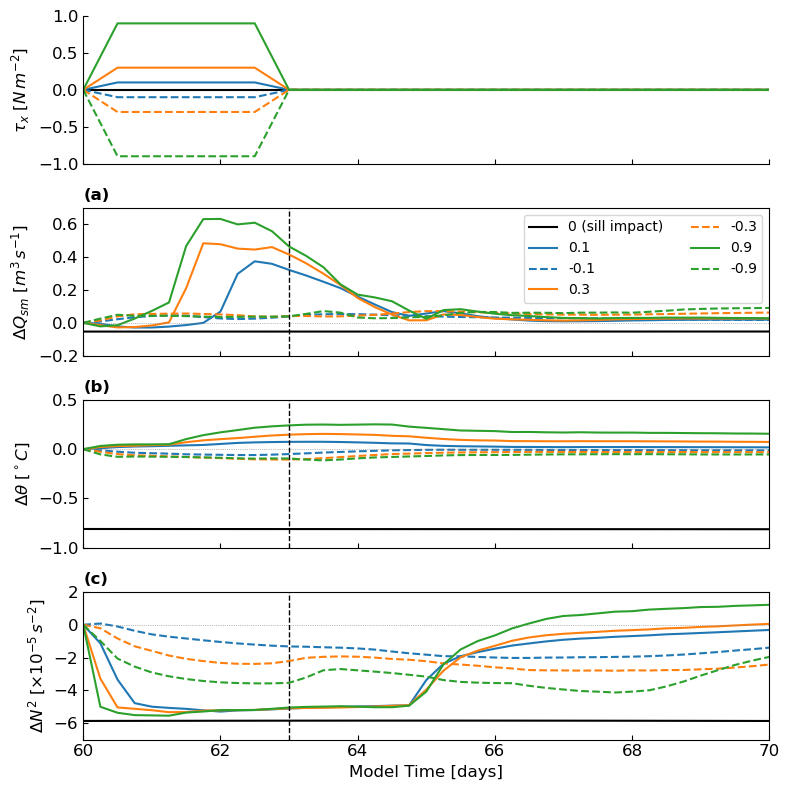

In [9]:
day = np.concatenate(([60], diagT/86400)) # Starting from 60d
theta_f = -1.67 # Freezing temperature of seawater
# Sill Impact (sill - nosill)
# dQsm = (Qsm1[-1] - Qsm2[-1]) * np.ones(len(day))
# dT = (Temp1[-1] - Temp2[-1]) * np.ones(len(day))
# dNsq = (Nsq1[-1] - Nsq2[-1]) * np.ones(len(day))

dQsm, dT, dNsq = Qsm3-Qsm4, Temp3-Temp4, Nsq3-Nsq4


# Time Series of Qsm, Temp, and Strat.
fig1, (ax0,ax1,ax2,ax3) = plt.subplots(4,1,sharex=True,tight_layout=True,figsize=(8,8))

colors = ['C0','C1','C2']
#colors = ['C0','C1']

# Wind Forcing
# pos_ax0 = ax0.get_position()
# # Adjust the height of the first subplot's position
# # New position: [left, bottom, width, height]
# # Here, 'height' is reduced and 'bottom' is adjusted to move the subplot up
# new_height = pos_ax0.height * 0.6  # For example, reduce the height by 40%
# #new_bottom = pos_ax0.y0 + (pos_ax0.height - new_height)  # Adjust bottom to move up
# ax0.set_position([pos_ax0.x0, pos_ax0.y0, pos_ax0.width, new_height])
for i in range(len(taum)):
    if i==0:
        ax0.plot(model_time/86400+60,wind[i,:],c='k',lw=1.5,label=str(taum[i]))
    else:
        ax0.plot(model_time/86400+60,wind[i,:],c=colors[i-1],lw=1.5,label=str(taum[i]))
        ax0.plot(model_time/86400+60,-wind[i,:],'--',c=colors[i-1],lw=1.5,label=str(-taum[i]))
ax0.set_ylabel(r'$\tau_x$ [$N\,m^{-2}$]',fontsize=12)
ax0.set_yticks([-1,-0.5,0,0.5,1])
ax0.tick_params(direction='in', labelsize=12)
# Remove the spines
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
#ax0.spines['bottom'].set_visible(False)
#ax0.set_xticks([])


# Submarine Melt
ax1.plot(day,np.concatenate(([Qsm1[-1] - Qsm2[-1]], dQsm)),'k-',lw=1.5, label='0 (sill impact)')
for i in range(len(tau_dw)):
    dQ1 = Qsm_DW[i]-Qsm1[-1]
    dQ2 = Qsm_UW[i]-Qsm1[-1]
    ax1.plot(day,np.concatenate(([0], dQ1)),'-',lw=1.5, c=colors[i], label=tau_dw[i])
    ax1.plot(day,np.concatenate(([0], dQ2)),'--',lw=1.5, c=colors[i], label=tau_uw[i])

#ax1.legend(loc='upper left',ncol=2,fontsize=10, bbox_to_anchor=(0.6, 2.1))
ax1.legend(loc='upper right',ncol=2,fontsize=10, )
ax1.set_ylim([-0.2, 0.7])
ax1.set_yticks([-0.2,0,0.2,0.4,0.6])
ax1.set_ylabel(r'$\Delta Q_{sm}$ [$m^3\,s^{-1}$]',fontsize=12)
ax1.tick_params(direction='in', labelsize=12)
ax1.set_title('(a)',loc='left', size=12,fontweight='bold')
#ax1.grid(ls='-', c='k', alpha=.5, lw=0.2)

# Glacier front temperature
ax2.plot(day,dT,'k-',lw=1.5, label='0 (sill impact)')
for i in range(len(tau_dw)):
    ax2.plot(day,Temp_DW[i]-Temp1[-1],'-',lw=1.5, c=colors[i], label=tau_dw[i])
    ax2.plot(day,Temp_UW[i]-Temp1[-1],'--',lw=1.5, c=colors[i], label=tau_uw[i])

ax2.set_ylim([-1, 0.5])
ax2.set_ylabel(r'$\Delta \theta$ [$^\circ C$]',fontsize=12)
ax2.tick_params(direction='in', labelsize=12)
ax2.set_title('(b)',loc='left', size=12,fontweight='bold')
#ax2.grid(ls='-', c='k', alpha=.5, lw=0.2)



# Stratification
ax3.plot(day,dNsq*1e5,'k-',lw=1.5, label='0 (sill impact)')
for i in range(len(tau_dw)):
    ax3.plot(day,(Nsq_DW[i]-Nsq1[-1])*1e5,'-',lw=1.5, c=colors[i], label=tau_dw[i])
    ax3.plot(day,(Nsq_UW[i]-Nsq1[-1])*1e5,'--',lw=1.5, c=colors[i], label=tau_uw[i])

ax3.set_ylim([-7, 2])
ax3.set_yticks([-6,-4,-2,0,2])
ax3.set_ylabel(r'$\Delta N^2$ [$\times 10^{-5}\,s^{-2}$]',fontsize=12)
ax3.tick_params(direction='in', labelsize=12)
ax3.set_title('(c)',loc='left', size=12,fontweight='bold')
#ax3.grid(ls='-', c='k', alpha=.5, lw=0.2)
ax3.set_xlabel('Model Time [days]',fontsize=12)

ax1.axhline(y=0, color='grey',ls=':',lw=.5)
ax2.axhline(y=0, color='grey',ls=':',lw=.5)
ax3.axhline(y=0, color='grey',ls=':',lw=.5)

ax0.set_xlim([60, 70])
xid = 63
#ax0.axvline(x=xid, color='k',ls='--',lw=1)
ax1.axvline(x=xid, color='k',ls='--',lw=1)
ax2.axvline(x=xid, color='k',ls='--',lw=1)
ax3.axvline(x=xid, color='k',ls='--',lw=1)

# ax0.set_xlim([60, 80])
# ax0.set_xticks([60,65,70,75,80])
# for xid in [63, 66, 69, 72]:
#     ax1.axvline(x=xid, color='k',ls='--',lw=1)
#     ax2.axvline(x=xid, color='k',ls='--',lw=1)
#     ax3.axvline(x=xid, color='k',ls='--',lw=1)

In [ ]:
figpath = '/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/'
fig1.savefig(figpath+'Qsm_T_Nsq_Wind1.png', dpi=300, bbox_inches='tight')